In [25]:
import pandas as pn
import numpy as np

PATH_TO_FOLDER_DATA = '../Mind-Collector/data/lol_2024-08-12T11-51-55/'

SAMPLING_RATE = 25 
DELAY = -15 # difference between game and timers in seconds

In [26]:
import os
def sort_imgs(imgs: list[str]) -> list[str]:
    return sorted(imgs, key=lambda x: int(x.split('_')[-1].split('.')[0]))

def list_files(dir=PATH_TO_FOLDER_DATA):
    files = os.listdir(dir)
    csv_file = [f for f in files if f.endswith('.csv')][0]
    imgs = [f for f in files if f.endswith('.png')]
    return csv_file, sort_imgs(imgs)

csv_file, imgs = list_files()

In [27]:
data = pn.read_csv(os.path.join(PATH_TO_FOLDER_DATA, csv_file))

C:\Users\kuban\AppData\Local\Temp\ipykernel_2812\568640471.py:1: DtypeWarning: Columns (70) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pn.read_csv(os.path.join(PATH_TO_FOLDER_DATA, csv_file))


In [28]:
def get_time(value):
    value += DELAY * SAMPLING_RATE
    minutes = value // (60 * SAMPLING_RATE)
    seconds = (value % (60 * SAMPLING_RATE)) // SAMPLING_RATE
    return f'{minutes}:{seconds}'

class Event:
    def __init__(self, index, img):
        self.index = index
        self.img = img
    def __repr__(self):
        return f'{get_time(self.index)} - {self.img}'

In [29]:
events_col = data.iloc[:, -1].astype(str)

event_names = np.unique(events_col)
event_names = event_names[event_names != '0']

ids = {e : events_col[events_col == e].index for e in event_names}
events: dict[str, list[Event]] = {name: [] for name in event_names}

for name in events:
    counter = 0
    for img in imgs:
        if name in img:
            event = Event(index=ids[name][counter], img=img)
            events[name].append(event)
            counter += 1

events['kill'][-1]

32:54 - kill_32.png

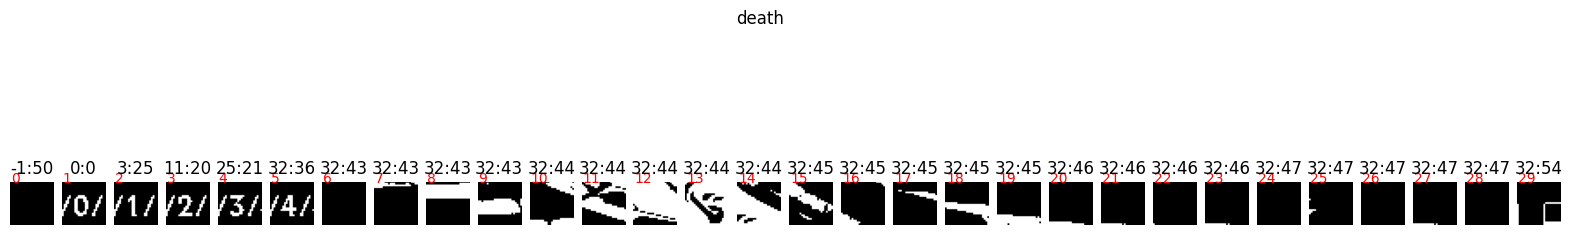

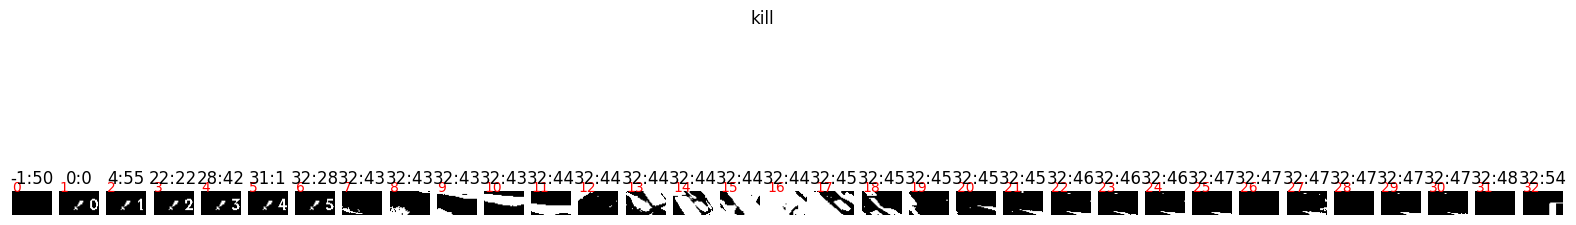

In [30]:
import matplotlib.pyplot as plt

def show_events(events):
    for event_name in events:
        fig, axs = plt.subplots(1, len(events[event_name]), figsize=(20, 4))
        fig.suptitle(event_name)
        for i, event in enumerate(events[event_name]):
            axs[i].imshow(plt.imread(os.path.join(PATH_TO_FOLDER_DATA, event.img)), cmap='gray')
            axs[i].set_title(get_time(event.index))
            axs[i].text(0, 0, i, color='red')
            axs[i].axis('off')
        plt.show()
show_events(events)

## Pass indexes (starting from 0) that should be cleared

In [37]:
TO_BE_CLEARED = {
    'death': [0,1,*list(range(6, 30))],
    'kill': [0,1,*list(range(7, 33))],
}
for event_type in TO_BE_CLEARED:
    print(f"{event_type}: {TO_BE_CLEARED[event_type]}")

death: [0, 1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
kill: [0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


Events after clearing:


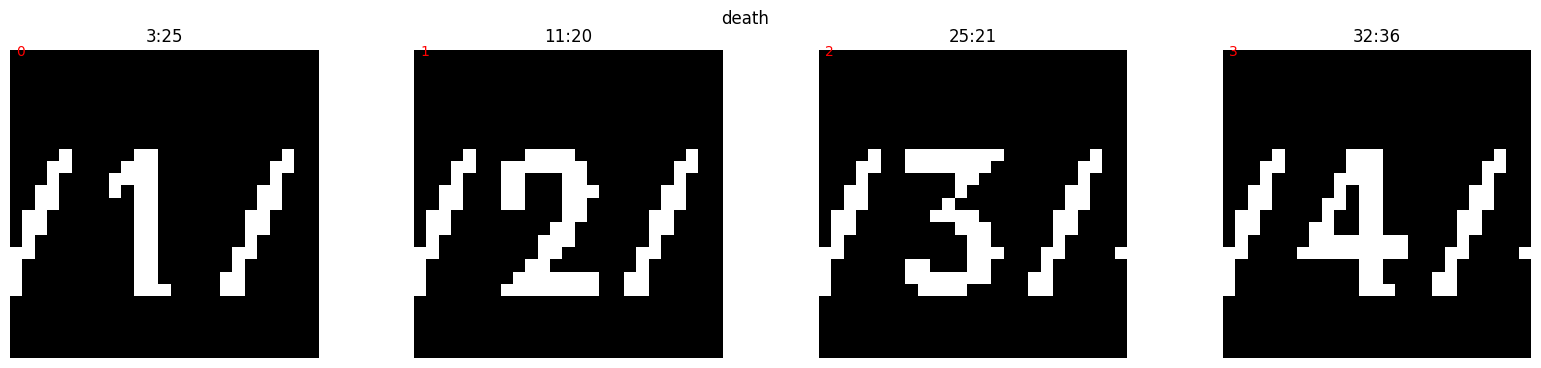

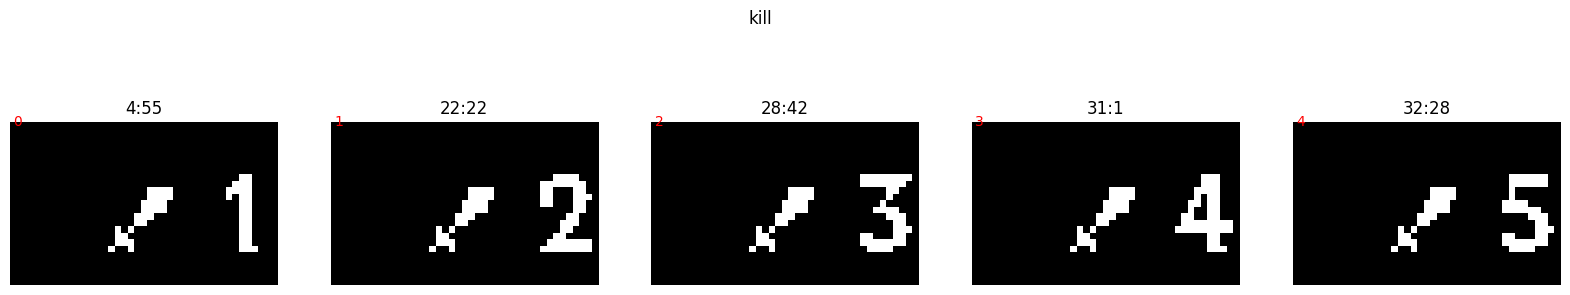

In [32]:
def clear_marker(id_to_clear, new_value=0):
    data.iloc[id_to_clear, -1] = new_value


answer = input('Do you want to clear the following events? (y/n)\n' + '\n'.join([f'{name}: {TO_BE_CLEARED[name]}' for name in TO_BE_CLEARED]) + '\n')
if answer != 'y':
    print('No events were cleared')
else:
    os.makedirs(os.path.join(PATH_TO_FOLDER_DATA, 'archive'), exist_ok=True)

    for name in TO_BE_CLEARED:
        for i in TO_BE_CLEARED[name]:
            clear_marker(events[name][i].index)
            os.rename(os.path.join(PATH_TO_FOLDER_DATA, events[name][i].img), os.path.join(PATH_TO_FOLDER_DATA, 'archive', events[name][i].img))
        events[name] = [e for i, e in enumerate(events[name]) if i not in TO_BE_CLEARED[name]]

    data.to_csv(os.path.join(PATH_TO_FOLDER_DATA, csv_file), index=False)
    
    print('Events after clearing:')
    show_events(events)